## Quantitative trading in China A stock market with FinRL (New Tensor Environment)

Install FinRL

In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Install other libraries

In [ ]:
!pip install stockstats
!pip install tushare
#install talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install
#!sudo make install # Sometimes it need root 
os.chdir('../')
!pip install TA-Lib

In [ ]:
%cd /
!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
%cd /FinRL-Meta/

In [182]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython import display
import seaborn as sns
display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.tushare import Tushare, ReturnPlotter
from meta.config import ( DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR
from agents.stablebaselines3_models import DRLAgent
pd.options.display.max_columns = None
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


Create Folders

In [ ]:
import os

''' 
use check_and_make_directories() to replace the following

if not os.path.exists("./datasets"): 
  os.makedirs("./datasets") 
if not os.path.exists("./trained_models"): 
  os.makedirs("./trained_models") 
if not os.path.exists("./tensorboard_log"): 
  os.makedirs("./tensorboard_log") 
if not os.path.exists("./results"): 
  os.makedirs("./results") 
'''

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [151]:
ticket_list=['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH']

train_start_date='2002-01-01'
train_stop_date='2019-08-01'
val_start_date='2019-08-01'
val_stop_date='2021-01-03'

token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'

In [152]:
ts_processor = Tushare(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=val_stop_date,
                                   time_interval="1d",
                                   token=token)
ts_processor.download_data(ticker_list=ticket_list)

100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Shape of DataFrame:  (65995, 8)


In [153]:
ts_processor.clean_data()
# ts_processor.dataframe

Shape of DataFrame:  (69150, 8)


In [154]:
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.clean_data()
# ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (61740, 17)


In [155]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)     
train.shape

(56550, 17)

### New env

In [156]:
import gym
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3.common.vec_env import DummyVecEnv

class StockTradingEnv_A_lookback(gym.Env):
    def __init__(self,config):
        self.df = config["data"]
        self.stock_dim = config["stock_dim"]                   # number of unique stocks
        self.hmax = config["hmax"]                             # maximum number of shares to trade
        self.buy_cost_pct = config["buy_cost_pct"]             # buy cost
        self.sell_cost_pct = config["sell_cost_pct"]           # sell cost
        self.reward_scaling = config["reward_scaling"]         # scaling factor for reward, good for training
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.force_zero_cash = config["force_zero_cash"] if "force_zero_cash" in config.keys() else True
        self.initial_amount = torch.tensor(config["initial_amount"],device=self.device) if "initial_amount" in config.keys() else torch.tensor(1e6,device=self.device)

        self.observation_space = gym.spaces.Box(low=-np.inf, high = np.inf, shape=(config["state_space"],))
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(config["action_space"], ))
                 
        self._read_file()
        self.reset()                            
    
    def _read_file(self):
        self.data = self.df.to_numpy()[:,3:].astype("float")
        self.data = torch.tensor(self.data.reshape(-1, self.stock_dim, self.data.shape[1]), dtype=float)   # (ts,sn,fn) 
        print(f"Total Steps: {self.data.shape[0]}")
        self.buy_price = torch.tensor(self.df.close.to_numpy().reshape(-1, self.stock_dim).astype("float") , dtype=float)      # (ts,sn)
        self.sell_price =  torch.tensor(self.df.close.to_numpy().reshape(-1, self.stock_dim).astype("float") , dtype=float)      # (ts,sn)
        # self.buy_price = self.buy_price/self.sell_price[0]
        # self.sell_price = self.sell_price/self.sell_price[0]

    def reset(self):
        self.today = [0]
        self.input_data = self.data[self.today].to(self.device)
        self.buy_data = self.buy_price[self.today].to(self.device)
        self.sell_data = self.sell_price[self.today].to(self.device)
        self.state = torch.concat([
            self.initial_amount.reshape(-1),
            torch.zeros(self.stock_dim, device=self.device),
            self.input_data.reshape(-1)],dim = 0)
            
        self.day_count = 0                           
        self.reward = 0                            
        self.cost = 0                              
        self.trades = 0                              
        self.episode = 0  
        
        self.episode+=1  
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []  
        self.actions_memory = []
        self.state_memory = [torch.zeros(self.stock_dim, device=self.device).cpu().numpy()]
        
        return self.state.reshape(-1).cpu().numpy()

    def step(self,actions):
        with torch.no_grad():
            self.terminal = self.today[-1] >= self.data.shape[0]-1
            # print(self.today)
            # print(self.terminal)
            self.day_count += 1

            actions = torch.tensor(actions,device=self.device)
            actions = actions.to(dtype = torch.float64)
            # actions -= torch.mean(actions,keepdim=True,dim = 0)

            start_cash = self.state[0]
            start_hold = self.state[1:(self.stock_dim+1)]
            mid_data = (self.buy_data + self.sell_data)/2
            begin_asset =  self.asset_memory[-1] # start asset

            # check stock > 0
            next_hold = start_hold + actions
            zero_hold = torch.zeros_like(next_hold,dtype=torch.float64 ,device=self.device)
            next_hold = torch.where( next_hold <= 0, zero_hold, next_hold)  # >0

            # check hold change
            hold_change = next_hold - start_hold

            zero_actions =  torch.zeros_like( actions,dtype=torch.float64 ).to(self.device)
            sell_actions = torch.where( hold_change >= 0, zero_actions, hold_change) # <0
            buy_actions = torch.where( hold_change <= 0, zero_actions, hold_change)  # >0

            sell_money = torch.sum( -self.sell_data * sell_actions * ( 1 - self.sell_cost_pct ))
            buy_money = torch.sum( self.buy_data * buy_actions * (1 + self.buy_cost_pct))

            sell_money += start_cash

            # force zero cash
            if self.force_zero_cash:
                if buy_money <  sell_money:
                    if buy_money != 0:
                        factor = sell_money / buy_money
                        zero_factor = torch.zeros_like(factor,device=self.device)
                        factor = torch.where(torch.isnan(factor), zero_factor, factor)
                        factor = torch.where(torch.isinf(factor), zero_factor, factor)
                        buy_actions *= factor
                        buy_money *= factor
                    else:
                        factor = sell_money/torch.sum(self.buy_data* (1 + self.buy_cost_pct))
                        zero_factor = torch.zeros_like(factor,device=self.device)
                        factor = torch.where(torch.isnan(factor), zero_factor, factor)
                        factor = torch.where(torch.isinf(factor), zero_factor, factor)
                        buy_actions = factor.reshape(-1).repeat_interleave(self.stock_dim,dim = 0)
                        buy_money = sell_money
                if buy_money >  sell_money:
                    if sell_money != 0:
                        factor = buy_money / sell_money 
                        zero_factor = torch.zeros_like(factor,device=self.device)
                        factor = torch.where(torch.isnan(factor), zero_factor, factor)
                        factor = torch.where(torch.isinf(factor), zero_factor, factor)
                        sell_actions *= factor
                        sell_money *= factor
                    else:
                        factor = - buy_money/torch.sum(self.sell_data* (1 - self.sell_cost_pct))
                        zero_factor = torch.zeros_like(factor,device=self.device)
                        factor = torch.where(torch.isnan(factor), zero_factor, factor)
                        factor = torch.where(torch.isinf(factor), zero_factor, factor)
                        sell_actions = factor.reshape(-1).repeat_interleave(self.stock_dim,dim = 0)
                        sell_money = buy_money
            else:  # check cash > 0
                if buy_money >  sell_money:
                    factor = sell_money / buy_money
                    zero_factor = torch.zeros_like(factor,device=self.device)
                    factor = torch.where(torch.isnan(factor), zero_factor, factor)
                    factor = torch.where(torch.isinf(factor), zero_factor, factor)  
                    buy_actions *= factor
                    buy_money *= factor
            
            hold_change = sell_actions + buy_actions
            next_cash = sell_money - buy_money
            next_hold = start_hold + hold_change
            
            next_asset = torch.sum( next_hold* mid_data) + next_cash
            self.reward = next_asset - begin_asset   
            self.reward = self.reward * self.reward_scaling
            self.rewards_memory.append(self.reward)
            self.asset_memory.append(next_asset) 
            self.actions_memory.append(actions.cpu().numpy())
            self.state_memory.append(next_hold.cpu().numpy())

            if self.terminal:
                print(f"Episode: {self.episode}")
                total_reward =  torch.sum(torch.stack(self.rewards_memory,dim = -1))
                total_reward_pct =total_reward/self.asset_memory[0]
                print(f"Cumulated Return:  {total_reward}, Cumulated Return Rate:  {total_reward_pct}")

            else:
                # update everything
                self.today = [i+1 for i in self.today]    # day
                self.input_data = self.data[self.today].to(self.device)
                self.buy_data = self.buy_price[self.today].to(self.device)
                self.sell_data = self.sell_price[self.today].to(self.device)

                self.state = torch.concat([
                    next_cash.reshape(-1),next_hold,self.input_data.reshape(-1)],dim = 0)
                
            return self.state.reshape(-1).cpu().numpy(), self.reward.cpu().numpy(), self.terminal,{}
    
    def render(self, figsize= (20,5)):
        pd.DataFrame([0]+[i.cpu().item() for i in self.rewards_memory]).plot(title ="rewards_memory",figsize = figsize,legend = False)
        plt.show()
        pd.DataFrame([i.cpu().item() for i in self.asset_memory]).plot(title ="asset_memory",figsize = figsize,legend = False)
        plt.show()
        sns.heatmap(self.actions_memory)
        plt.show()
        sns.heatmap(self.state_memory)
        plt.show()

    def save_asset_memory(self):
        date_list = [i for i in range(len(self.asset_memory ))]      # 日期列表
        asset_list = [i.cpu().item() for i in self.asset_memory]     # 财产列表
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = [i for i in range(len(self.actions_memory ))] 
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = range(self.stock_dim)
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})

        return df_actions

    def save_state_memory(self):
        # date and close price length must match actions length
        date_list = [i for i in range(len(self.state_memory ))] 
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        state_list = self.state_memory
        df_state = pd.DataFrame(state_list)
        df_state.columns = range(self.stock_dim)
        df_state.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})

        return df_state
    
    def save_reward_memory(self):
        date_list = [i for i in range(len(self.rewards_memory ))]      # 日期列表
        rewards_list = [i.cpu().item() for i in self.rewards_memory]     # 财产列表
        df_account_value = pd.DataFrame({'date':date_list,'account_value':rewards_list})
        return df_account_value

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [157]:
train_env_kwargs = {
    "data":train,
    "stock_dim":15,
    "hmax":100,
    "buy_cost_pct":0.001,
    "sell_cost_pct":0.001,
    "reward_scaling":1e-2,
    "state_space": 1+15*15,
    "action_space":15,
    "force_zero_cash":False
}
e_train_gym = StockTradingEnv_A_lookback(train_env_kwargs)

Total Steps: 3770


In [158]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [159]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 1024, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

{'batch_size': 1024, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device


In [160]:
import time
start_time = time.time()
trained_ddpg = agent.train_model(model=model_ddpg, 
                              tb_log_name='ddpg',
                              total_timesteps=50000)
end_time = time.time()
new_time = (end_time-start_time)/60
new_time

Logging to tensorboard_log/ddpg\ddpg_10
Episode: 1
Cumulated Return:  26061.740956958787, Cumulated Return Rate:  0.026061740956958786
Episode: 1
Cumulated Return:  28708.55516588241, Cumulated Return Rate:  0.028708555165882412
Episode: 1
Cumulated Return:  29208.91070454872, Cumulated Return Rate:  0.029208910704548723
Episode: 1
Cumulated Return:  29218.016820414032, Cumulated Return Rate:  0.02921801682041403
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 204        |
|    time_elapsed    | 73         |
|    total_timesteps | 15080      |
| train/             |            |
|    actor_loss      | 3.79e+03   |
|    critic_loss     | 1.58e+05   |
|    learning_rate   | 0.0005     |
|    n_updates       | 11310      |
|    reward          | -243.20525 |
-----------------------------------
Episode: 1
Cumulated Return:  29170.5288103983, Cumulated Return Rate:  0.0291705288103983
Episode: 1
Cumulated Ret

6.084182834625244

### Old env

In [169]:
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.INDICATORS)+2)+1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 151


In [170]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym_old = StockTradingEnv(df = train, **env_kwargs)

In [171]:
env_train_old, _ = e_train_gym_old.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [172]:
agent_old = DRLAgent(env = env_train_old)
DDPG_PARAMS = {
                "batch_size": 1024, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg_old = agent_old.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

{'batch_size': 1024, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device


In [174]:
import time
start_time = time.time()
trained_ddpg_old = agent_old.train_model(model=model_ddpg_old, 
                              tb_log_name='ddpg',
                              total_timesteps=50000)
end_time = time.time()
old_time = (end_time-start_time)/60
old_time

Logging to tensorboard_log/ddpg\ddpg_12
Episode: 3
day: 3769, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 10598669.96
total_reward: 9598669.96
total_cost: 5788.46
total_trades: 56533
Sharpe: 0.659
Episode: 4
day: 3769, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1214679.75
total_reward: 214679.75
total_cost: 511.25
total_trades: 56535
Sharpe: 0.203
Episode: 5
day: 3769, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2359726.53
total_reward: 1359726.53
total_cost: 480.47
total_trades: 56535
Sharpe: 0.342
Episode: 6
day: 3769, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 2338736.52
total_reward: 1338736.52
total_cost: 480.48
total_trades: 56535
Sharpe: 0.340
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 87        |
|    time_elapsed    | 173       |
|    total_timesteps | 15080     |
| train/             |           |
|    actor_loss      | -34.2     |
|  

10.949732132752736

In [176]:
new_time/old_time

0.5556467282360537

### Trade

In [162]:
trade = ts_processor.data_split(ts_processor.dataframe, val_start_date, val_stop_date)
trade_env_kwargs = {
    "data":trade,
    "stock_dim":15,
    "hmax":100,
    "buy_cost_pct":0.001,
    "sell_cost_pct":0.001,
    "reward_scaling":1e-4,
    "state_space": 1+15*15,
    "action_space":15
}
e_trade_gym = StockTradingEnv_A_lookback(trade_env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                       environment = e_trade_gym)

Total Steps: 346
Episode: 1
Cumulated Return:  100.54078243830915, Cumulated Return Rate:  0.00010054078243830915
hit end!


### Backtest

<AxesSubplot:ylabel='date'>

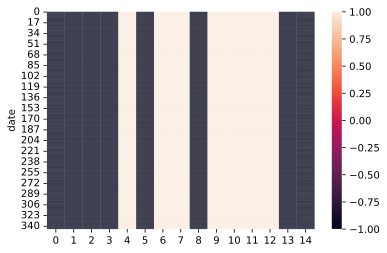

In [186]:
sns.heatmap(df_actions)

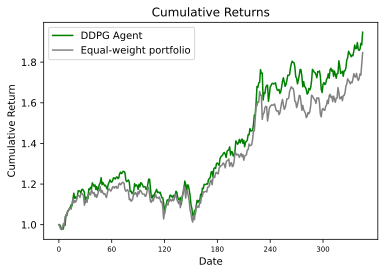

In [188]:
plotter = ReturnPlotter(df_account_value, trade, val_start_date, val_stop_date)
plotter.plot()

In [178]:
import akshare as ak

baseline_df = ak.stock_zh_index_daily(symbol="sz399300")
baseline_df.date = pd.to_datetime(baseline_df.date)
baseline_df = baseline_df[baseline_df.date >= val_start_date][baseline_df.date <= val_stop_date]
daily_return_base = baseline_df.set_index("date").close

In [179]:
sys.path.append(r"C:\Users\Olive\OneDrive\Documents\python_projects\aaai\Submit")
import pyfolio
from pyfolio import timeseries
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.624800
Cumulative returns     0.947295
Annual volatility      0.261080
Sharpe ratio           1.996720
Calmar ratio           3.451528
Stability              0.827207
Max drawdown          -0.181021
Omega ratio            1.407815
Sortino ratio          3.052298
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.353085
Daily value at risk   -0.030824
Alpha                       NaN
Beta                        NaN
dtype: float64

In [180]:
daily_return.index = pd.to_datetime(trade.date.unique())
daily_return_base = baseline_df.set_index("date").close

Start date,2019-08-01
End date,2020-12-31
Total months,16
,Backtest
Annual return,62.48%
Cumulative returns,94.73%
Annual volatility,26.108%
Sharpe ratio,2.00
Calmar ratio,3.45
Stability,0.83
Max drawdown,-18.102%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.10,2019-11-20,2020-03-20,2020-04-23,112
1,8.99,2020-09-02,2020-09-25,2020-11-24,60
2,8.84,2020-07-14,2020-07-27,2020-08-31,35
3,5.62,2019-09-09,2019-09-12,2019-09-19,9
4,4.62,2019-10-16,2019-10-25,2019-11-08,18


Stress Events,mean,min,max
New Normal,0.21%,-7.58%,5.12%


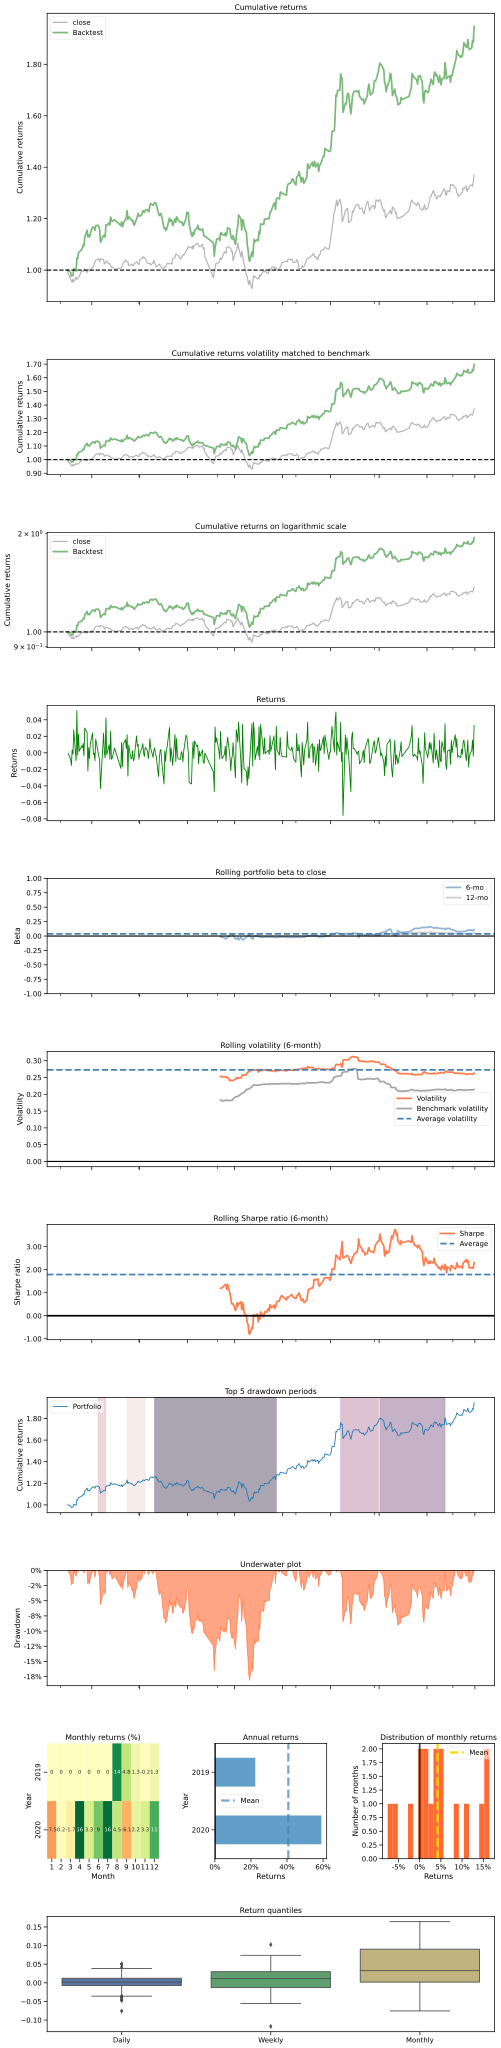

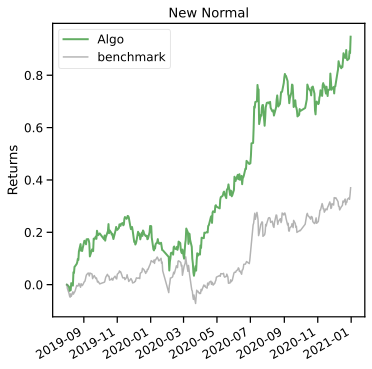

In [181]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base.pct_change(1), set_context=False)